## Import Basic Libraries

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d

# to import CycleDetector from 'model' file
model_dir = os.path.abspath('../model')
sys.path.append(model_dir)
from ejection_fraction.cycle_detection import CycleDetector

## Read Segemented Video

In [2]:
def read_video(video_dir, to_gray=True):
    """
    loads the video from the directory given
    :param video_dir: video address directory, str
    :param to_gray: makes the frames gray-scale if needed, bool
    :return: video_frames: video frames array, np.array
    :return: video_info: list of video information ( frame count, fps, duration ), list
    """

    # a list to be used for storing the frames
    video_frames = []

    # capturing the video with OpenCV lib.
    vidcap = cv2.VideoCapture(video_dir)

    frame_count = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    fps = vidcap.get(cv2.CAP_PROP_FPS)
    duration = frame_count / fps

    # counting the frames
    count = 0
    while vidcap.isOpened():
        success, frame = vidcap.read()
        if success:
            if to_gray:
                # converting the frames from rgb to gray-scale ( just for compression )
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # frame_label = self.process(frame)
            video_frames.append(frame)
            # video_labels.append(frame_label)
        else:
            break
        count += 1

    # releasing the video capture object
    vidcap.release()

    # validating the frame count
    if count != frame_count:
        frame_count = count

    video_info = [frame_count, fps, duration]
    return np.array(video_frames), video_info

In [10]:
video_dir = os.path.abspath('../notebooks/test_dataset/echonet_video_test/0X1A2A76BDB5B98BED/0X1A2A76BDB5B98BED_label.mp4').replace('\\','/')
video_frames, video_info = read_video(video_dir)
print('frame numbers:', video_frames.shape[0])
print('frame shapes: ({}, {})'.format(video_frames.shape[1], video_frames.shape[2]))

frame numbers: 201
frame shapes: (112, 112)


## Define Cycle Detector

In [4]:
es_ed_detection = CycleDetector(video_frames, method='radius')
volumes = np.array(es_ed_detection.frames_area)
cycles = es_ed_detection.find_cycles()
print(cycles)

[(20, 87), (66, 137), (115, 186)]


D:\AIMedic\FinalProject_echocardiogram\echoC_Codes\echotrain\model\ejection_fraction\cycle_detection.py:48: UserWarning: Using default value(s) for the parameter(s)
  warnings.warn('Using default value(s) for the parameter(s)')


### Find Peaks & Cycles

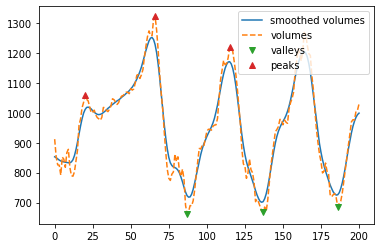

In [6]:
max_peaks_idx = [max_p[0] for max_p in cycles]
min_peaks_idx = [min_p[1] for min_p in cycles]
max_peaks_volumes = volumes[max_peaks_idx]
min_peaks_volumes = volumes[min_peaks_idx]

gs_volumes = gaussian_filter1d(volumes, sigma=3)

plt.plot(gs_volumes)
plt.plot(volumes, '--')
plt.plot(min_peaks_idx, min_peaks_volumes, 'v')
plt.plot(max_peaks_idx, max_peaks_volumes, '^')
plt.legend(['smoothed volumes', 'volumes', 'valleys','peaks'])
plt.show()

### Detect End-Diastole & End-Systole Frames

In [8]:
ed_frame, es_frame, ed_idx, es_idx = es_ed_detection.detect_ed_es()
print('end diastole frame number:', ed_idx)
print('end systole frame number:', es_idx)

end diastole frame number: 66
end systole frame number: 137


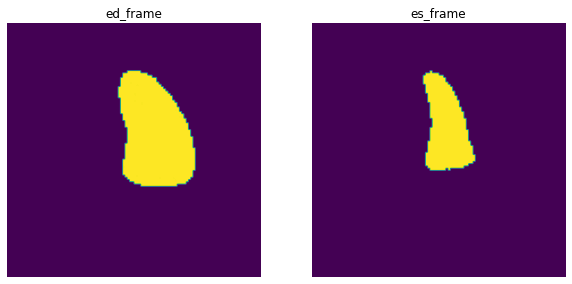

In [16]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches((10, 5))

ax[0].axis('off')
ax[0].set_title('ed_frame')
ax[0].imshow(ed_frame)

ax[1].axis('off')
ax[1].set_title('es_frame')
ax[1].imshow(es_frame)